Evaluate VIC-GRU predictions from the GRIP-E project

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
import hydroeval
from src import load_data, evaluate
import netCDF4 as nc

In [2]:
vic_obj1 = nc.Dataset('../../data/vic-gru_phase_1_objective_1.nc', 'r')
vic_obj2 = nc.Dataset('../../data/vic-gru_phase_1_objective_2.nc', 'r')

In [3]:
obj1_streamflow = vic_obj1['Q'][:]
obj1_times = vic_obj1['time']
obj1_idx = nc.num2date(obj1_times[:], obj1_times.units)

obj2_streamflow = vic_obj2['Q'][:]
obj2_times = vic_obj2['time']
obj2_idx = nc.num2date(obj2_times[:], obj2_times.units)

In [4]:
vic_obj1 = pd.DataFrame(obj1_streamflow, index=vic_obj1['station_id'][:], columns=obj1_idx)
vic_obj2 = pd.DataFrame(obj2_streamflow, index=vic_obj2['station_id'][:], columns=obj2_idx)

In [5]:
duplicates = list(s for s in vic_obj2.index.values if s in vic_obj1.index.values)

In [6]:
vic_predictions = vic_obj1.append(vic_obj2).drop_duplicates()
vic_predictions = vic_predictions.unstack().reset_index().rename({'level_0': 'date', 'level_1': 'station', 0: 'vic_prediction'}, axis=1)

In [7]:
ground_truth = load_data.load_discharge_gr4j_vic()

In [8]:
ground_truth = ground_truth[~pd.isna(ground_truth['runoff'])]

In [9]:
data = pd.merge(ground_truth, vic_predictions, on=['date', 'station'])
data = data[data['date'] > '2010-12-31']  # ignore warm-up period

04159492 NSE: 0.5042524324539539	MSE: 193.09333460447988
04200500 NSE: 0.44540096547313135	MSE: 662.8151877355341
04161820 NSE: 0.1404231960666834	MSE: 32.180173953575995
04174500 NSE: -0.23169131643460328	MSE: 203.45096027893803
02GC010 NSE: 0.4244904619233295	MSE: 30.65323427623447
02GE007 NSE: 0.49524548492328335	MSE: 17.58793407948303
02GD004 NSE: 0.36867953382695406	MSE: 30.613663230792753
04214500 NSE: 0.4491269669037514	MSE: 67.1759088544791
04213000 NSE: 0.587183431743875	MSE: 90.71120206462956
02GG009 NSE: 0.261156394332852	MSE: 124.47908970573009
02GA010 NSE: 0.16722363668430817	MSE: 311.2281246402271
04176500 NSE: 0.499052663071873	MSE: 613.6481426129558
04177000 NSE: 0.5057673644699119	MSE: 24.594063422577918
02GA047 NSE: -0.04718784653587571	MSE: 72.3830339229913
02GC018 NSE: 0.40072836319931526	MSE: 48.60869329713117
04166500 NSE: -2.285008896619926	MSE: 181.65507949203712
04207200 NSE: 0.5912608787312188	MSE: 14.59700021463095
04160600 NSE: 0.5430890688589322	MSE: 13.971

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


02GG006 NSE: 0.28829766318309313	MSE: 42.49809553139936
04193500 NSE: 0.7462912752117734	MSE: 23062.87870635496
02GC007 NSE: -1.9109673320955887	MSE: 91.67278584746651
04208504 NSE: 0.7113070985591023	MSE: 471.61677198744326
04199000 NSE: 0.45419486835298184	MSE: 645.2422637954631
02GG002 NSE: 0.434933065006623	MSE: 120.78547488140654
04213500 NSE: 0.590026434540356	MSE: 376.7111915286102
02GA038 NSE: 0.293800575527723	MSE: 89.72967510989392
04198000 NSE: 0.5195286321505905	MSE: 3925.334369675191
04197100 NSE: 0.47391479051342666	MSE: 73.71560215310969
02GB007 NSE: 0.251172735662212	MSE: 23.332788484837202
04165500 NSE: 0.46511052787798635	MSE: 273.04633791250956
02GG013 NSE: 0.3152534960848107	MSE: 30.70259956863795
02GC002 NSE: 0.42703923370306285	MSE: 76.41837008892784
04212100 NSE: 0.645276014301469	MSE: 775.3719976188352
04199500 NSE: 0.4739787998632633	MSE: 292.5865711479492
04196800 NSE: 0.4209217402706281	MSE: 202.88120368819156
04166100 NSE: -9.585464459538478	MSE: 104.7497807

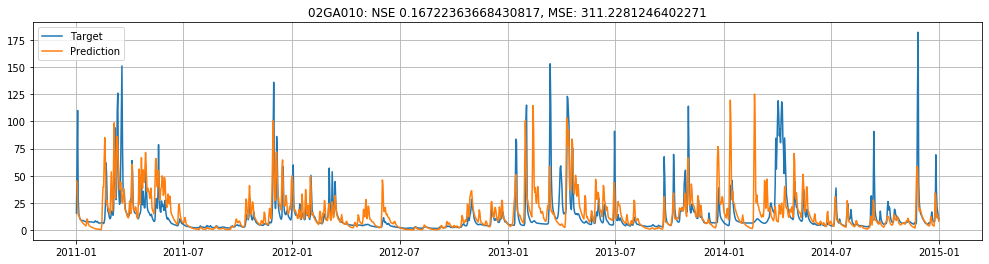

In [10]:
plot_list = ['02GA010']
nse_list, mse_list = [], []
for station in data['station'].unique():
    station_data = data[data['station']==station].set_index('date')
    
    nse, mse = evaluate.evaluate_daily(station, station_data[['vic_prediction']], station_data['runoff'], plot=station in plot_list)
    nse_list.append(nse)
    mse_list.append(mse)
    print('{} NSE: {}\tMSE: {}'.format(station, nse, mse))

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

2011
Skipping 04214500
Median NSE (clipped to 0) 0.5298781489037612 / Min 0.028793445024567044 / Max 0.6142277418120499
Median MSE (clipped to 0) 41.222944205646364 / Min 22.9381265060153 / Max 1019.1477952089934
2012
Median NSE (clipped to 0) 0.34689535978678815 / Min -24.837344896692734 / Max 0.795966541642421
Median MSE (clipped to 0) 41.74572652236267 / Min 4.448463448125443 / Max 9145.346173967715
2013
Median NSE (clipped to 0) 0.422297734201356 / Min -10.863273610034696 / Max 0.7895080492376346
Median MSE (clipped to 0) 118.48444164655302 / Min 7.45203609527003 / Max 15876.591660351974
2014
Median NSE (clipped to 0) 0.016673244289774902 / Min -12.925756228414022 / Max 0.6717612931303117
Median MSE (clipped to 0) 132.7990772164608 / Min 11.785524340865523 / Max 32434.12544922466


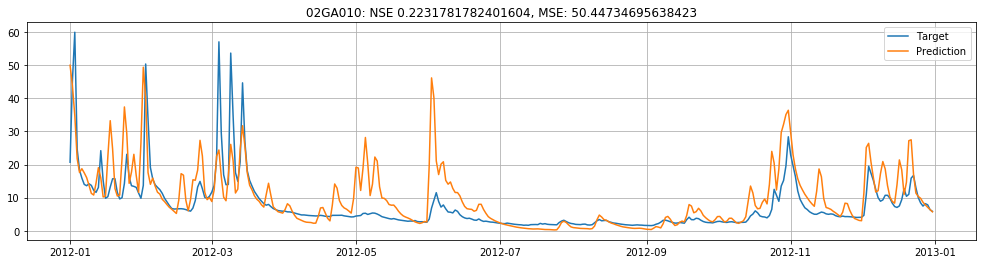

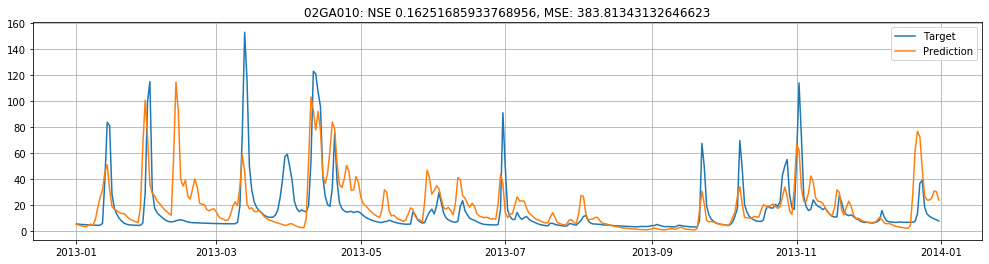

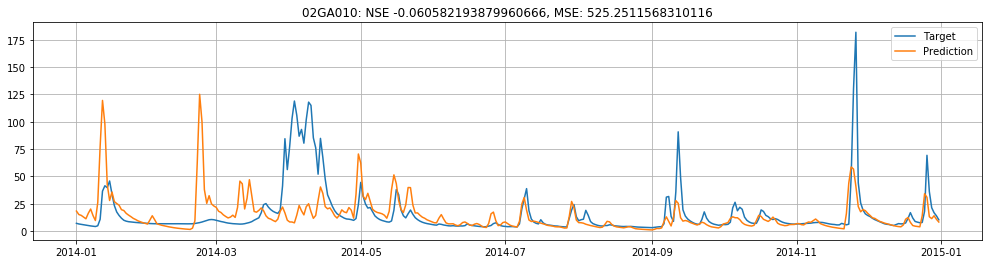

In [11]:
plot_list = ['02GA010']
for year in ['2011', '2012', '2013', '2014']:
    print(year)
    nse_list, mse_list = [], []
    for station in data['station'].unique():
        station_data = data[data['station']==station].set_index('date').loc[year:year]
        
        if len(station_data) == 0:
            print('Skipping', station)
            break
        
        station_data = station_data[year]
        nse, mse = evaluate.evaluate_daily(station, station_data[['vic_prediction']], station_data['runoff'], plot=station in plot_list)
        nse_list.append(nse)
        mse_list.append(mse)

    print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
    print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))